In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
dirpath = "landscape.jpg"
img_src = cv2.imread(dirpath)

In [3]:
img_src.shape

(315, 474, 3)

In [4]:
img_cv = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

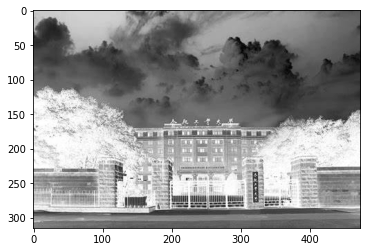

In [5]:
plt.imshow(img_cv, cmap=plt.cm.binary)
plt.show()

## 滤波

In [6]:
sobel_x = np.asarray([[-1,0,1],[-2,0,2],[-1,0,1]]) # sobel 检测垂直边缘算子
cornel_size = 3 # 卷积核尺寸

In [7]:
def filter_func(cornel, image_src):
    image_shape = image_src.shape
    filter_img = np.zeros(image_shape)  # 初始化结果矩阵
    pad_size = cornel.shape[0] // 2  # 计算半径
    
    for h in tqdm(range(pad_size, image_shape[0] - pad_size)):
        for w in range(pad_size, image_shape[1] - pad_size):
            temp_array = image_src[h - pad_size:h + pad_size + 1, w - pad_size:w + pad_size + 1]
            conv_res = temp_array * cornel
            conv_sum = np.sum(conv_res)
            filter_img[h, w] = conv_sum  # 赋值
    return filter_img

In [8]:
sobel_x_filter = filter_func(sobel_x,img_cv)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 305.19it/s]


In [9]:
sobel_x_filter.shape

(315, 474)

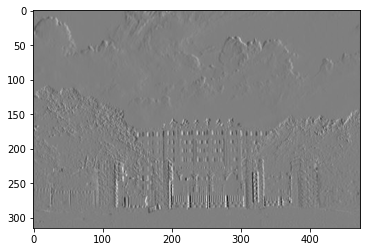

In [10]:
plt.imshow(sobel_x_filter, cmap=plt.cm.binary)
plt.show()

In [11]:
input_cornel = np.asarray([[1,0,-1],[2,0,-2],[1,0,-1]])
input_filter_result = filter_func(input_cornel,img_cv)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 256.90it/s]


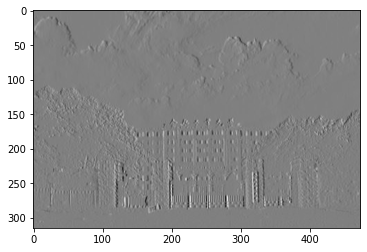

In [12]:
plt.imshow(input_filter_result, cmap=plt.cm.binary)
plt.show()

## 直方图计算

In [13]:
def image_histogram(image_src):
    # 提取图片的直方图特征
    image_shape = image_src.shape
    histogram = [0 for i in range(256)]
    
    for h in range(image_shape[0]):
        for w in range(image_shape[1]):
#                 print(image_src[h,w,c])
            histogram[image_src[h,w]] += 1
    return histogram

In [14]:
histogram = image_histogram(img_cv)

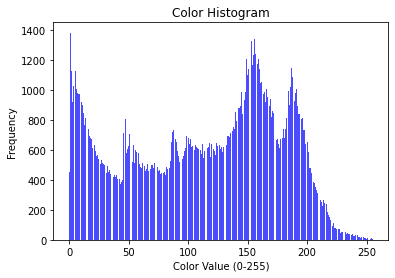

In [15]:
# 绘制直方图
plt.bar(range(256), histogram, color='blue', alpha=0.7)
plt.title('Color Histogram')
plt.xlabel('Color Value (0-255)')
plt.ylabel('Frequency')
plt.show()

## LBP算法纹理特征提取

In [16]:
 def lbp_textual(image_src,cell_size=3):
        #提取lbp 图像局部纹理特征
        import copy
        image_shape = image_src.shape
        feature_matrix = []
        lbp_image = np.zeros(image_shape)
#         for c in range(image_shape[2]):
        for h in tqdm(range(0,image_shape[0],cell_size)):
            for w in range(0,image_shape[1],cell_size):
                cell = image_src[h:h+cell_size,w:w+cell_size]
                cell_count = np.zeros(256)
                for x in range(1,cell_size-1):
                    for y in range(1,cell_size-1):
                        center = cell[x,y]
                        lbpcode = 0 
                        lbpcode |= (cell[x-1,y-1] > center) << 7
                        lbpcode |= (cell[x,y-1] > center) << 6
                        lbpcode |= (cell[x+1,y-1] > center) << 5
                        lbpcode |= (cell[x+1,y] > center) << 4
                        lbpcode |= (cell[x+1,y+1] > center) << 3
                        lbpcode |= (cell[x,y+1] > center) << 2
                        lbpcode |= (cell[x-1,y+1] > center) << 1
                        lbpcode |= (cell[x-1,y] > center) << 0  
                        cell_count[lbpcode] += 1 # 记录出现频率
                        lbp_image[h+x,w+y] = lbpcode                             
                    min_count = np.min(cell_count)
                    max_count = np.max(cell_count)
                    cell_count_norm = (cell_count - min_count)/(max_count-min_count)
                    # 将归一化后的直方图添加到特征矩阵
                    feature_matrix.append(copy.deepcopy(cell_count_norm)) # 深拷贝                
        # 将特征矩阵转换为NumPy数组
        textual_feature_matrix = np.array(feature_matrix)
        return textual_feature_matrix,lbp_image

In [19]:
textual_feature,lbp_filter_image = lbp_textual(img_cv)

100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 198.81it/s]


In [20]:
# 保存为 .npy 文件
np.savez_compressed('textual_feature.npy', textual_feature)

In [21]:
textual_feature.shape

(16590, 256)

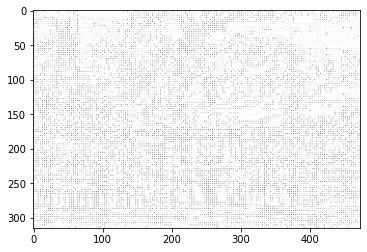

In [22]:
# 展示lbp特征提取效果
plt.imshow(lbp_filter_image, cmap=plt.cm.binary)
plt.show()